<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset (Copy from CNN.ipynb and merge cells)

In [3]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 

import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()


snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

Xsnr = np.zeros(shape=(X.shape[0],X.shape[1],X.shape[2]+1))
for i in range(X.shape[0]):
    snr = int(labels[i,1])
    Xsnr[i,0,:] = np.insert(X[i,0,:],0,snr)
    Xsnr[i,1,:] = np.insert(X[i,1,:],0,snr)
    
print(Xsnr.shape)

###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 1, random_state = 0)

print(X_train.shape)
print(X_test.shape)


X_train = X_train[:,:,1:] # snr important for train

y_test18 = []
X_test18 = []

for i in range(X_test.shape[0]):
    if X_test[i,0,0] == 18:
        X_test18.append(X_test[i])
        y_test18.append(y_test[i])
        
X_test18 = np.array(X_test18)
y_test18 = np.array(y_test18)        
X_test18 = X_test18[:,:,1:]


print(X_train.shape)
print(X_test18.shape)


# Change IQ to amplitude and phase
X_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_train_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##
X_cmplx = X_test18[:,0,:] + 1j* X_test18[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_test18[:,1,:],X_test18[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_test18_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##

print(X_train_AmpPhs.shape)
print(X_test18_AmpPhs.shape)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = X_train.reshape([X_train.shape[0],256])
#X_train = X_train_AmpPhs.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test18 = X_test18.reshape([X_test18.shape[0],256])
#X_test18 = X_test18_AmpPhs.reshape([X_test18.shape[0],256])
X_test18 = sc.transform(X_test18)
X_test18 = X_test18.reshape([X_test18.shape[0],2,128])

# Reshape
X_train = X_train.reshape(-1,2, 128, 1)   #Reshape for CNN -  (6400,2,128)->(6400,2,128,1)!!
X_test18 = X_test18.reshape(-1,2, 128, 1)

print(X_train.shape)
print(X_test18.shape)

loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


SNR : 18
(160000, 2, 129)
(128000, 2, 129)
(32000, 2, 129)
(128000, 2, 128)
(1653, 2, 128)
(128000, 2, 128)
(1653, 2, 128)
(128000, 2, 128, 1)
(1653, 2, 128, 1)


## Import Module

In [0]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import concatenate
from keras.layers.convolutional import ZeroPadding2D


#Making DenseNet0 model (three-convolutional-layer)
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
dout = 0.5

modelInput = Input(shape=(2,128,1))

x1 = Conv2D(filters = 128,kernel_size = (1,3), padding='same', activation = 'relu')(modelInput)
x1 = Dropout(rate=dout)(x1)

#x2 = ZeroPadding2D(padding = (0,1))(x1)
x2 = Conv2D(filters = 64,kernel_size = (2,3), padding='same', activation = 'relu')(x1)
x2 = Dropout(rate=dout)(x2)

concat1 = concatenate([x1,x2])

x3 = Conv2D(filters = 64,kernel_size = (1,3), padding='same', activation = 'relu')(concat1)
x3 = Dropout(rate=dout)(x3)

x4 = Flatten()(x3)

x5 = Dense(output_dim = 128 , activation = 'relu')(x4)
x5 = Dropout(rate=dout)(x5)

out = Dense(output_dim = 8 , activation = 'softmax')(x5)


classifier = Model(inputs = modelInput, outputs = out)

classifier.summary()

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print("Model Created!")

Fully Dense

In [0]:
dout = 0.5

modelInput = Input(shape=(2,128,1))

x1 = Conv2D(filters = 128,kernel_size = (1,3), padding='same', activation = 'relu')(modelInput)
x1 = Dropout(rate=dout)(x1)

concat1 = concatenate([x1,modelInput])

#x2 = ZeroPadding2D(padding = (0,1))(x1)
x2 = Conv2D(filters = 64,kernel_size = (2,3), padding='same', activation = 'relu')(concat1)
x2 = Dropout(rate=dout)(x2)

concat2 = concatenate([x2,x1,modelInput])

x3 = Conv2D(filters = 64,kernel_size = (1,3), padding='same', activation = 'relu')(concat2)
x3 = Dropout(rate=dout)(x3)

concat3 = concatenate([x3,x2,x1,modelInput])

x4 = Flatten()(concat3)

x5 = Dense(output_dim = 128 , activation = 'relu')(x4)
x5 = Dropout(rate=dout)(x5)

out = Dense(output_dim = 8 , activation = 'softmax')(x5)


classifier = Model(inputs = modelInput, outputs = out)

classifier.summary()

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print("Model Created!")

#Making DenseNet1 model (four-convolutional-layer)
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
dout = 0.5

modelInput = Input(shape=(2,128,1))

x1 = Conv2D(filters = 128,kernel_size = (1,3), padding='same', activation = 'relu')(modelInput)
x1 = Dropout(rate=dout)(x1)

x2 = Conv2D(filters = 128,kernel_size = (2,3), padding='same', activation = 'relu')(x1)
x2 = Dropout(rate=dout)(x2)

concat1 = concatenate([x1,x2], axis=3)

x3 = Conv2D(filters = 64,kernel_size = (1,3), padding='same', activation = 'relu')(concat1)
x3 = Dropout(rate=dout)(x3)

concat2 = concatenate([x1,x2,x3], axis=3)

x4 = Conv2D(filters = 64,kernel_size = (1,3), padding='same', activation = 'relu')(concat2)
x4 = Dropout(rate=dout)(x4)

x5 = Flatten()(x4)

x6 = Dense(output_dim = 128 , activation = 'relu')(x5)
x6 = Dropout(rate=dout)(x5)

out = Dense(output_dim = 8 , activation = 'softmax')(x6)

classifier = Model(inputs = modelInput, outputs = out)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

print("Model Created!")

#Making DenseNet2 model (five-convolutional-layer)
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
dout = 0.5

modelInput = Input(shape=(2,128,1))

x1 = Conv2D(filters = 128,kernel_size = (1,7), padding='same', activation = 'relu')(modelInput)
x1 = Dropout(rate=dout)(x1)

x2 = Conv2D(filters = 128,kernel_size = (2,5), padding='same', activation = 'relu')(x1)
x2 = Dropout(rate=dout)(x2)

concat1 = concatenate([x1,x2], axis=3)

x3 = Conv2D(filters = 128,kernel_size = (1,3), padding='same', activation = 'relu')(concat1)
x3 = Dropout(rate=dout)(x3)

concat2 = concatenate([x1,x2,x3], axis=3)

x4 = Conv2D(filters = 64,kernel_size = (1,3), padding='same', activation = 'relu')(concat2)
x4 = Dropout(rate=dout)(x4)

concat3 = concatenate([x1,x2,x3,x4], axis=3)

x5 = Conv2D(filters = 64,kernel_size = (1,3), padding='same', activation = 'relu')(concat3)
x5 = Dropout(rate=dout)(x5)

x6 = Flatten()(x5)

x7 = Dense(output_dim = 128 , activation = 'relu')(x6)
x7 = Dropout(rate=dout)(x7)

out = Dense(output_dim = 8 , activation = 'softmax')(x7)

classifier = Model(inputs = modelInput, outputs = out)

classifier.summary()

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print("Model Created!")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2, 128, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 128, 256)  1536        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2, 128, 256)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 128, 128)  196736      dropout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=8)`


# Fitting model

In [0]:
batch = 1024
epoch = 100

history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch, validation_data=(X_test18, y_test18))
#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 128000 samples, validate on 1653 samples
Epoch 1/100
128000/128000 [==============================] - 120s 939us/step - loss: 1.7589 - acc: 0.2712 - val_loss: 0.9651 - val_acc: 0.5191
Epoch 2/100
128000/128000 [==============================] - 114s 887us/step - loss: 1.4310 - acc: 0.3718 - val_loss: 0.8253 - val_acc: 0.5747
Epoch 3/100
 70656/128000 [===============>..............] - ETA: 50s - loss: 1.3710 - acc: 0.3912

KeyboardInterrupt: ignored

# Save model

In [0]:
dic = "/content/drive/My Drive/Colab Notebooks/"
classifier.save(dic+f'SaveModel/DenseNet5-256(1,5)-128(2,3)-128(1,3)-64(1,3)-64(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR=all).h5')
f = open(dic+f'SaveModel/DenseNet5-256(1,5)-128(2,3)-128(1,3)-64(1,3)-64(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR=all)-history.txt',"w")
f.write( str(classifier.history.history) )
f.close()

print('Model Saved!')


# Prediction(only SNR=18)

In [0]:
y_pred = classifier.predict(X_test18)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test18, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)


# Plot Confusion Matrix

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)    

128000/128000 [==============================] - 25s 192us/step
Acc Test :  0.9352692075736293
Acc Train :  0.6452734375


SNR:  -20
1636/1636 [==============================] - 0s 197us/step
0.13141809290953546
Plot Saved!
SNR:  -18
1630/1630 [==============================] - 0s 208us/step
0.12883435589221356
Plot Saved!
SNR:  -16
1606/1606 [==============================] - 0s 197us/step
0.14009962641955312
Plot Saved!
SNR:  -14
1633/1633 [==============================] - 0s 210us/step
0.13288426209430496
Plot Saved!
SNR:  -12
1567/1567 [==============================] - 0s 203us/step
0.15124441604364733
Plot Saved!
SNR:  -10
1561/1561 [==============================] - 0s 193us/step
0.19218449707427596
Plot Saved!
SNR:  -8
1605/1605 [==============================] - 0s 215us/step
0.2778816199469789
Plot Saved!
SNR:  -6
1605/1605 [==============================] - 0s 201us/step
0.3931464174826197
Plot Saved!
SNR:  -4
1600/1600 [==============================] - 0s 195us/step
0.511875
Plot Saved!
SNR:  -2
1642/1642 [==============================] - 0s 194us/step
0.6814859927644393
Plot Saved!
SNR:  0


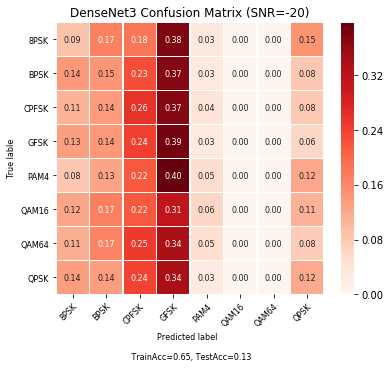

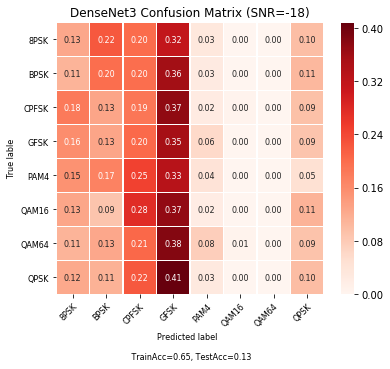

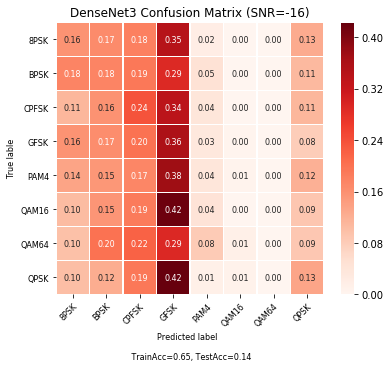

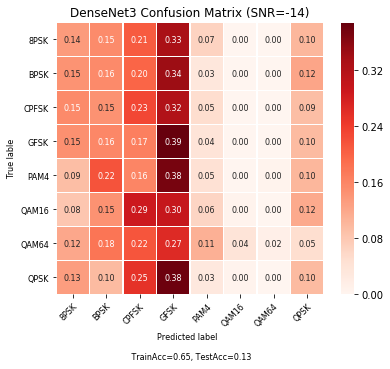

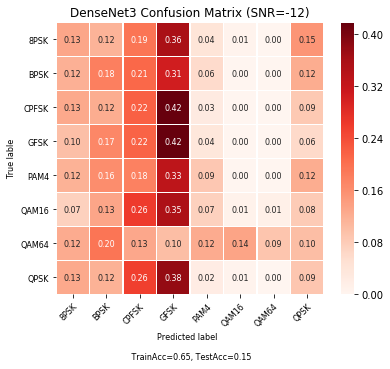

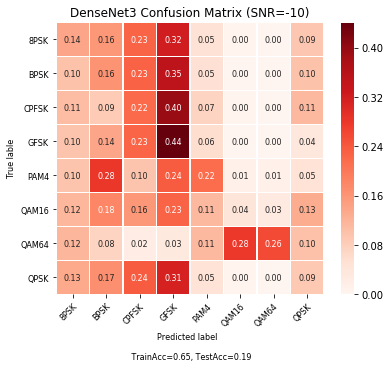

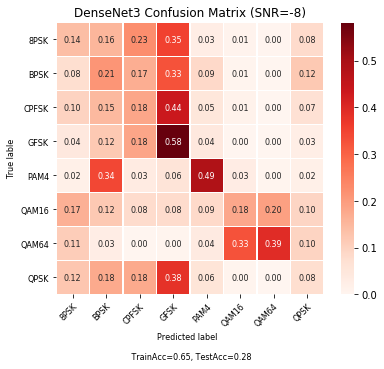

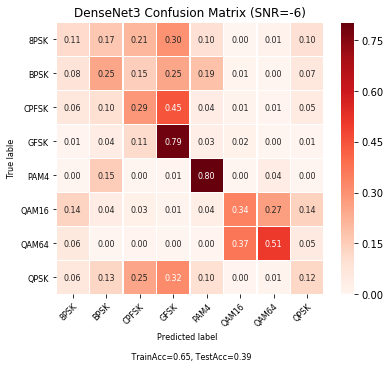

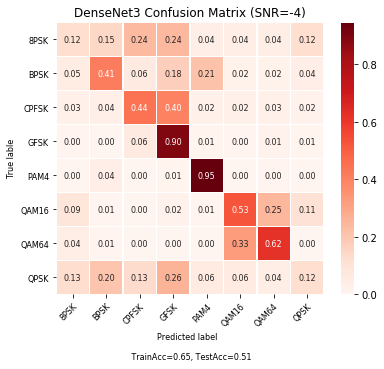

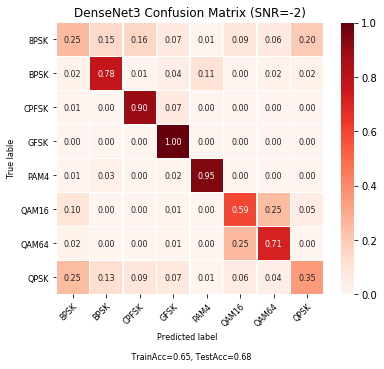

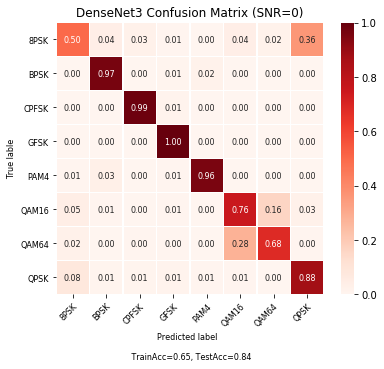

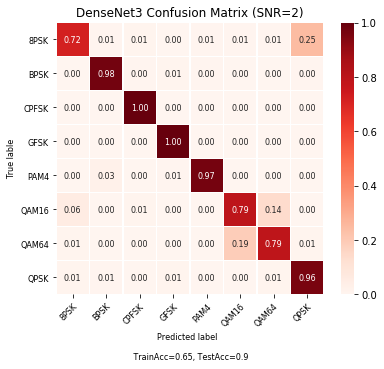

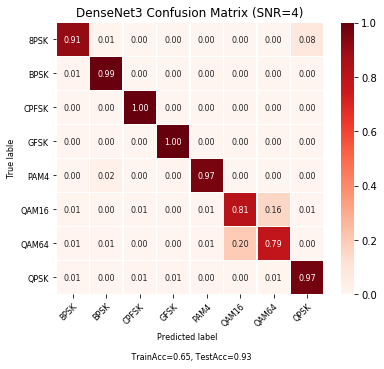

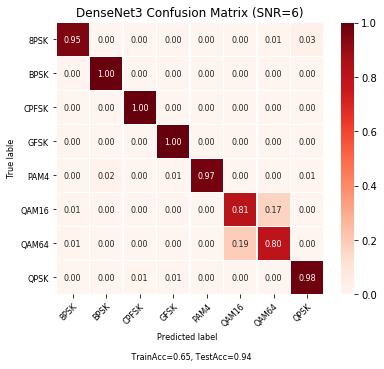

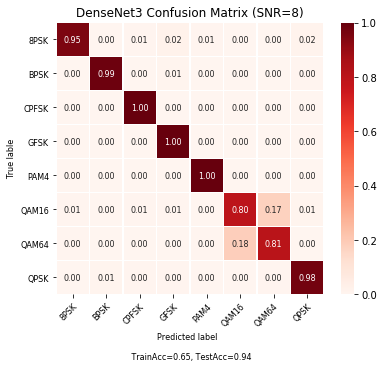

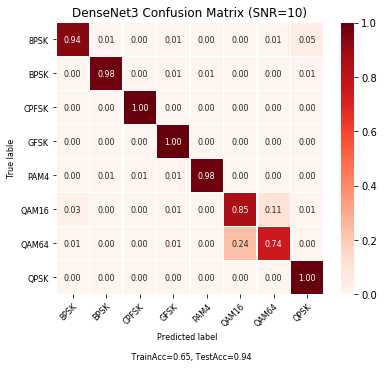

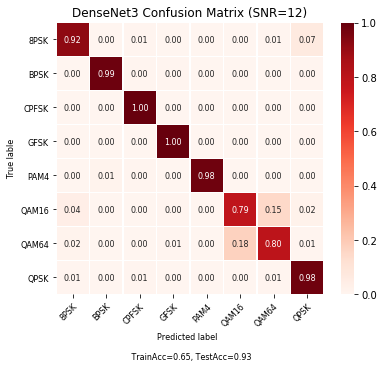

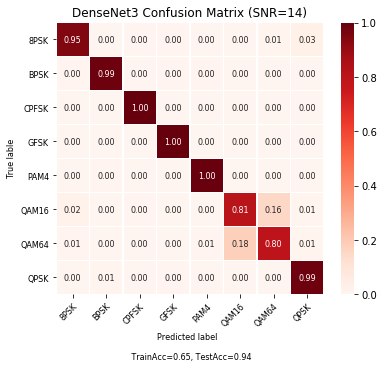

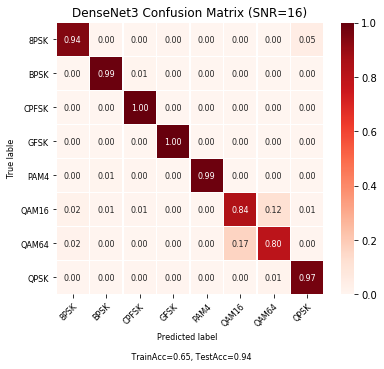

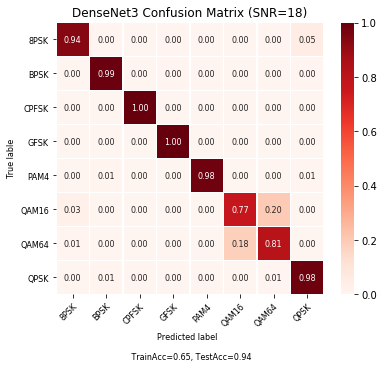

In [18]:
dic = "/content/drive/My Drive/Colab Notebooks/"
acc = []

for snr in snrList:
  print('SNR: ', snr)
    
  y_test_snr = []
  X_test_snr = []
  for i in range(X_test.shape[0]):
    if X_test[i,0,0] == int(snr):
      X_test_snr.append(X_test[i])
      y_test_snr.append(y_test[i])
        
  X_test_snr = np.array(X_test_snr)
  y_test_snr = np.array(y_test_snr)        
  X_test_snr = X_test_snr[:,:,1:]
  
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],256])
  X_test_snr = sc.transform(X_test_snr)
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],2,128])
  
  X_test_snr = X_test_snr.reshape(-1,2, 128, 1) # For CNN
    
  acc_test = classifier.evaluate(X_test_snr, y_test_snr)[1]
  acc.append(acc_test)
  print(acc_test)
  '''
  y_pred = classifier.predict(X_test_snr)
  y_pred = np.argmax(y_pred, axis=1)

  y_real = np.argmax(y_test_snr, axis=1)
  # Making the Confusion Matrix
  cm = confusion_matrix(y_real, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
  cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
  plt.figure(figsize=(6, 5))
  ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Reds")

  plt.title(f"DenseNet3 Confusion Matrix (SNR={snr})")
  plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
  plt.ylabel("True lable", fontsize=8)
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
  plt.setp(ax.get_yticklabels(), fontsize=8)
  fig = ax.get_figure()

  fig.savefig(dic+f"/Pic/DenseNet/DenseNet3-128(1,3)-64(2,3)-64(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR={snr}).png", dpi=175, bbox_inches='tight')
  fig.savefig(dic+f"/Pic/DenseNet/DenseNet3-128(1,3)-64(2,3)-64(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR={snr}).eps", bbox_inches='tight')
  print("Plot Saved!")
'''

  del(y_test_snr)
  del(X_test_snr)
      
print(acc)    
    

In [8]:
from keras.models import load_model
dic = "/content/drive/My Drive/Colab Notebooks/"
batch = 1024
epoch = 100
model = load_model(dic+f'SaveModel/CNN4-256(1,5)-128(2,3)-128(1,3)-64(1,3)-64(1,3)-ba{batch}-ep{epoch}-(dout=0.5)-input(IQ)(SNR=all).h5')
model = load_model(dic+f'SaveModel/DenseNet3-128(1,3)-64(2,3)-64(1,3)-ba1024-ep100-(dout=0.5)-input(IQ)(SNR=all).h5')
print('Model loaded!')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model loaded!


In [9]:
classifier = model
classifier.get_config()






{'input_layers': [['input_3', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 2, 128, 1),
    'dtype': 'float32',
    'name': 'input_3',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_3'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 128,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (1, 3),
    'name': 'conv2d_7',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_3', 0, 0, {}]]],
